In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier 
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as IPipeline
from xgboost import XGBClassifier

/home/joshua/anaconda3/envs/learn-env/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
train_multi = pd.read_parquet('../data/cleaned/train_multi.parquet')
X_train_multi = train_multi.drop('classification', axis = 1)
y_train_multi = train_multi.classification
test_multi = pd.read_parquet('../data/cleaned/test_multi.parquet')
X_test_multi = test_multi.drop('classification', axis = 1)
y_test_multi = test_multi.classification

In [4]:
train_binary = pd.read_parquet('../data/cleaned/train_binary.parquet')
X_train_binary = train_binary.drop('disposition', axis = 1)
y_train_binary = train_binary.disposition
test_binary = pd.read_parquet('../data/cleaned/test_binary.parquet')
X_test_binary = test_binary.drop('disposition', axis = 1)
y_test_binary = test_binary.disposition

In [5]:
y_train_multi.value_counts()

0    1932
2     823
3     296
1     287
4      70
Name: classification, dtype: int64

In [6]:
y_train_binary.value_counts()

1    2364
0    1928
Name: disposition, dtype: int64

In [20]:
def run_model(X_train, X_test, y_train, y_test, estimator,
              resampling = None, grid_search = False, grid_params = None, cv = None, plot_confusion = True):
    
    numeric_col = X_train.select_dtypes('number').columns.values.tolist()
    object_col = X_train.select_dtypes('object').columns.values.tolist()
    steps_no_resampling = [('ssc', StandardScaler(), numeric_col), ('ohe', OneHotEncoder(), object_col)]
    preprocess_no_resampling = ColumnTransformer(steps_no_resampling)
    
    if resampling is None:
        steps = [('preprocess', preprocess_no_resampling), estimator]
        if not grid_search:
            model = Pipeline(steps = steps)
        else:
            pipe = Pipeline(steps = steps)
            model = GridSearchCV(pipe, grid_params = grid_params, cv = cv)
    else:
        steps = [('preprocess', preprocess_no_resampling), resampling, estimator]
        if not grid_search:
            model = IPipeline(steps = steps)
        else:
            pipe = IPipeline(steps = steps)
            model = GridSearchCV(pipe, grid_params = grid_params, cv = cv)
    
    model.fit(X_train, y_train)
    
    if plot_confusion:
        ConfusionMatrixDisplay(confusion_matrix(y_test, model.predict(X_test))).plot();
        
    return model

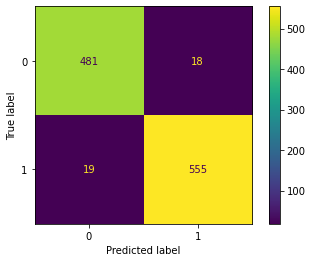

In [21]:
base_logistic_pipe = run_model(X_train_binary, X_test_binary, y_train_binary, y_test_binary,
                               ('logreg', LogisticRegression(random_state = 42, max_iter = 1000)),
                               plot_confusion = True)

In [15]:
numeric_col = X_train_multi.select_dtypes('number').columns.values.tolist()
object_col = X_train_multi.select_dtypes('object').columns.values.tolist()

steps_no_SMOTE = [('ssc', StandardScaler(), numeric_col), ('ohe', OneHotEncoder(), object_col)]
preprocess_no_SMOTE = ColumnTransformer(steps_no_SMOTE)
steps_with_SMOTE = [('transformer', preprocess_no_SMOTE), ('smote', SMOTE(random_state = 42))]
preprocess_with_SMOTE = IPipeline(steps = steps_with_SMOTE)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       499
           1       0.97      0.97      0.97       574

    accuracy                           0.97      1073
   macro avg       0.97      0.97      0.97      1073
weighted avg       0.97      0.97      0.97      1073



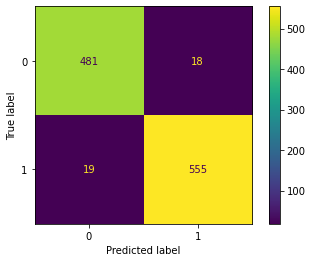

In [18]:
base_logistic_pipe = Pipeline([('preprocess', preprocess_no_SMOTE),
                               ('logreg', LogisticRegression(random_state = 42, max_iter = 1000))])

base_logistic_pipe.fit(X_train_binary, y_train_binary)
base_logistic_pipe.score(X_test_binary, y_test_binary)
print(classification_report(y_test_binary, base_logistic_pipe.predict(X_test_binary)))
ConfusionMatrixDisplay(confusion_matrix(y_test_binary, base_logistic_pipe.predict(X_test_binary))).plot();

In [57]:
X_train_bin_no_objnum = X_train_binary.drop('num_of_objects_around_star', axis = 1)
X_test_bin_no_objnum = X_test_binary.drop('num_of_objects_around_star', axis = 1)

In [62]:
numeric_col_test = X_train_bin_no_objnum.select_dtypes('number').columns.values.tolist()
object_col_test = X_train_bin_no_objnum.select_dtypes('object').columns.values.tolist()

steps_no_SMOTE_test = [('ssc', StandardScaler(), numeric_col_test), ('ohe', OneHotEncoder(), object_col_test)]
preprocess_no_SMOTE_test= ColumnTransformer(steps_no_SMOTE_test)

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       499
           1       0.97      0.96      0.97       574

    accuracy                           0.96      1073
   macro avg       0.96      0.96      0.96      1073
weighted avg       0.96      0.96      0.96      1073

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('ssc', StandardScaler(),
                                                  ['right_ascension',
                                                   'declination', 'g_band_mag',
                                                   'r_band_mag', 'i_band_mag',
                                                   'z_band_mag', 'j_band_mag',
                                                   'h_band_mag', 'k_band_mag',
                                                   'kepler_band_mag',
                                                   'num_of_transits',
                                        

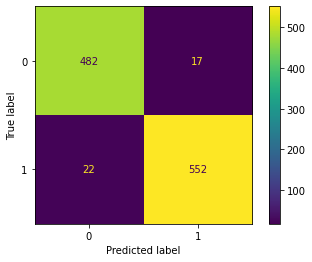

In [89]:
base_logistic_no_objnum_pipe = Pipeline([('preprocess', preprocess_no_SMOTE_test),
                               ('logreg', LogisticRegression(random_state = 42))])

grid_search_test = GridSearchCV(base_logistic_no_objnum_pipe,
                               param_grid = {'logreg__C': [0.001, 0.01, 1, 100, 1000, 10_000, 100_000]}, cv = 5)

grid_search_test.fit(X_train_bin_no_objnum, y_train_binary)
print(classification_report(y_test_binary, grid_search_test.predict(X_test_bin_no_objnum)))
ConfusionMatrixDisplay(confusion_matrix(y_test_binary, grid_search_test.predict(X_test_bin_no_objnum))).plot();
print(grid_search_test.best_estimator_, grid_search_test.best_score_)

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       499
           1       0.97      0.96      0.97       574

    accuracy                           0.97      1073
   macro avg       0.97      0.97      0.97      1073
weighted avg       0.97      0.97      0.97      1073



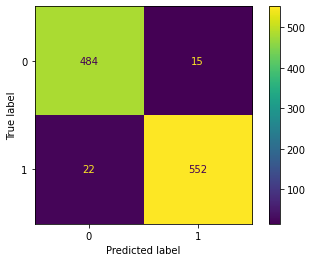

In [50]:
base_logistic_pipe_SMOTE = IPipeline([('preprocess', preprocess_no_SMOTE),
                                      ('smote', SMOTE(random_state = 42)),
                                      ('logreg', LogisticRegression(random_state = 42))])
# IPipeline([('preprocess', preprocess_with_SMOTE),
#                                ('logreg', LogisticRegression(random_state = 42))])

base_logistic_pipe_SMOTE.fit(X_train_binary, y_train_binary)
base_logistic_pipe_SMOTE.score(X_test_binary, y_test_binary)
print(classification_report(y_test_binary, base_logistic_pipe_SMOTE.predict(X_test_binary)))
ConfusionMatrixDisplay(confusion_matrix(y_test_binary, base_logistic_pipe_SMOTE.predict(X_test_binary))).plot();

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       495
           1       0.63      0.59      0.61        66
           2       0.88      0.85      0.86       194
           3       0.77      0.76      0.76        78
           4       0.31      0.47      0.38        19

    accuracy                           0.87       852
   macro avg       0.71      0.72      0.71       852
weighted avg       0.88      0.87      0.88       852



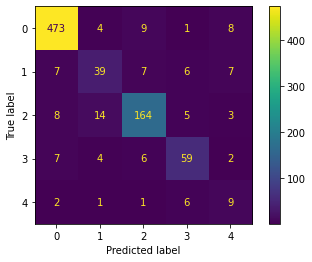

In [51]:
base_decision_tree = Pipeline([('preprocess', preprocess_no_SMOTE),
                               ('tree', DecisionTreeClassifier(random_state = 42))])

base_decision_tree.fit(X_train_multi, y_train_multi)
base_decision_tree.score(X_test_multi, y_test_multi)
print(classification_report(y_test_multi, base_decision_tree.predict(X_test_multi)))
ConfusionMatrixDisplay(confusion_matrix(y_test_multi, base_decision_tree.predict(X_test_multi))).plot();

              precision    recall  f1-score   support

           0       0.96      0.88      0.92       495
           1       0.52      0.73      0.60        66
           2       0.85      0.76      0.80       194
           3       0.67      0.76      0.71        78
           4       0.17      0.37      0.24        19

    accuracy                           0.82       852
   macro avg       0.63      0.70      0.65       852
weighted avg       0.85      0.82      0.83       852



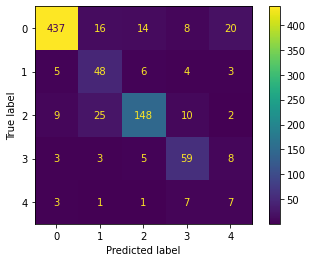

In [52]:
base_decision_tree_SMOTE = IPipeline([('preprocess', preprocess_no_SMOTE),
                                      ('smote', SMOTE(random_state = 42)),
                                      ('tree', DecisionTreeClassifier(random_state = 42))])
base_decision_tree_SMOTE.fit(X_train_multi, y_train_multi)
base_decision_tree_SMOTE.score(X_test_multi, y_test_multi)
print(classification_report(y_test_multi, base_decision_tree_SMOTE.predict(X_test_multi)))
ConfusionMatrixDisplay(confusion_matrix(y_test_multi, base_decision_tree_SMOTE.predict(X_test_multi))).plot();

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       495
           1       0.55      0.59      0.57        66
           2       0.86      0.79      0.82       194
           3       0.75      0.81      0.78        78
           4       0.27      0.32      0.29        19

    accuracy                           0.86       852
   macro avg       0.68      0.69      0.68       852
weighted avg       0.86      0.86      0.86       852



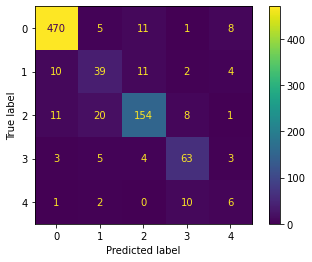

In [91]:
base_decision_tree_RandomOverSampler = IPipeline([('preprocess', preprocess_no_SMOTE),
                                      ('ros', RandomOverSampler(random_state = 42)),
                                      ('tree', DecisionTreeClassifier(random_state = 42))])
base_decision_tree_RandomOverSampler.fit(X_train_multi, y_train_multi)
base_decision_tree_RandomOverSampler.score(X_test_multi, y_test_multi)
print(classification_report(y_test_multi, base_decision_tree_RandomOverSampler.predict(X_test_multi)))
ConfusionMatrixDisplay(confusion_matrix(y_test_multi, base_decision_tree_RandomOverSampler.predict(X_test_multi))).plot();